## Pretrained models

### Torchvision

[torchvision](https://github.com/pytorch/vision) - библиотека, содержащая популярные CV датасеты, утилиты для препроцессинга и, самое важное, pre-trained модели для классификации, обученные на [ImageNet](http://image-net.org/).

Большая часть потребностей покрывается имеющимися моделями, но если нужна какая-то другая архитектура или нужно решать задачу, отличную от классификации, то хорошую реализацию и веса, скорее всего, получится нагуглить или найти на github

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import os
from pathlib import Path
from copy import deepcopy
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import torchvision
import torch
import torch.nn as nn
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline

In [3]:
model = torchvision.models.resnet50(pretrained=True)
model.train(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Transfer learning

### Как достать признаки?

- переопределить последний слой так, чтобы он ничего не делал (неплохой вариант, но что, если нужны признаки из внутрненнего слоя?)
- написать хук, который будет возвращать признаки (хороший вариант)
- покромсать сетку и делать forward pass только для тех слоев, которые нужны (плохой вариант)


#### Способ 1. Переопределить последний слой

***ВНИМАНИЕ 1:*** Серьезная проблема `torchvision` - отсутствие единого интерфейса у моделей. В каждой реализации слои имеют разные имена и при единовременной работе с разными моделями приходится писать обвязку из условий. Если использовать реализации других архитектур, то ситуация только ухудшается

***ВНИМАНИЕ 2:*** В отличие от **Keras**, в **PyTorch** не принято делать последним слоем активацию. Нужная функция применяется при написании train / inference кода

In [4]:
model = torchvision.models.resnet50(pretrained=True)
features_model = deepcopy(model)

features_model.fc = nn.Identity()

dummy_x = torch.randn(1, 3, 224, 224)
features = features_model(dummy_x)
features_shape = features.data.numpy().shape
assert features_shape == (1, 2048), 'expected (1, 2048), but real is {}'.format(features_shape)

#### Способ 2. Forward hook

In [5]:
avgpool_features = None

def get_features(module, inputs, output):
    global avgpool_features   
    avgpool_features = np.squeeze(output.data.cpu().numpy(), axis=(2, 3))

model = torchvision.models.resnet50(pretrained=True)
model.avgpool.register_forward_hook(get_features)

dummy_x = torch.randn(1, 3, 224, 224)
model(dummy_x)

assert avgpool_features.shape == (1, 2048), 'expected (1, 2048), but real is {}'.format(avgpool_features.shape)

tensor([[-9.9639e-01, -3.5620e-01, -5.4927e-01, -1.1321e+00, -6.1480e-01,
         -3.0801e-01, -7.8674e-01,  4.7470e-01,  2.0920e-01, -5.3878e-01,
         -7.5800e-01, -8.1716e-01, -3.5546e-01, -7.6188e-01, -7.8857e-01,
         -2.1343e-01, -5.8919e-01, -1.0711e-01, -2.9439e-02, -4.0059e-01,
         -9.9207e-01, -6.2346e-01, -1.1495e+00, -2.3744e-02, -7.6257e-01,
         -6.6946e-01, -7.6003e-01, -6.1467e-01, -5.4146e-01, -5.7744e-01,
         -6.5179e-01, -8.3131e-01, -5.9012e-01, -3.8707e-01, -8.7791e-02,
         -4.2141e-01,  7.8128e-01, -4.2688e-01, -3.4995e-01,  2.7546e-01,
         -5.4929e-01, -5.5651e-01, -5.9523e-01, -1.8528e-01, -2.0560e-01,
         -2.5315e-01, -5.1025e-01, -3.5744e-01, -9.8034e-01, -5.7702e-01,
         -2.3869e-01,  4.8123e-01, -3.2483e-01, -3.1035e-01, -1.7122e-01,
         -9.0604e-01, -3.9869e-01, -9.1392e-01, -1.3031e-01, -1.1294e-01,
          6.8305e-01,  8.8471e-02,  4.0220e-02, -2.3483e-03, -6.1643e-01,
         -2.2955e-01, -3.2423e-01, -2.

### Обучение на признаках

Обучим обычный sklearn-классификатор, которому на вход подадим признаки из нейросети

В качестве датасета будем использовать данные конкурса https://www.kaggle.com/c/dogs-vs-cats/data, https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

Датасет содержит 25000 изображений кошек и собак, по 12500 каждого класса. Задача: определить, к какому классу относится конкретное изображение

Для определения качества моделей будем использовать метрику ROC-AUC

Скачаем и подготовим данные. Выделим 30% на валидацию

In [6]:
# !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip 
# !unzip kagglecatsanddogs_3367a.zip

In [7]:
data_path = Path('PetImages')
cat_fnames = [str(p) for p in (data_path / 'Cat').glob('*.jpg')][:1000]
dog_fnames = [str(p) for p in (data_path / 'Dog').glob('*.jpg')][:1000]
all_names = cat_fnames + dog_fnames
labels = np.array([0] * len(cat_fnames) + [1] * len(dog_fnames))

train_fnames, val_fnames, y_train, y_val = train_test_split(
    all_names, labels, test_size=0.3,
    random_state=42, shuffle=True, stratify=labels,
)

В **PyTorch** можно удобно работать с данными с помощью классов `Dataset` и `DataLoader`

Напишем свой датасет для расчет признаков изображений

In [8]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, shape):
        self._fnames = fnames
        self._transform = torchvision.transforms.Compose([
            
            torchvision.transforms.Resize(shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        fname = self._fnames[index]
        img = Image.open(fname).convert('RGB')
        img = self._transform(img)

        return img

    def __len__(self):
        return len(self._fnames)

Теперь нужно как-то рассчитать признаки.

Воспользуемся способом с хуком, но чтобы обойтись без глобальной переменной реализуем класс `FeatureExtractor`

In [9]:
class FeatureExtractor:
    def __init__(self, model, device='cuda'):
        self._model = model
        self._avgpool_features = None
        self._device = device
        self._model.avgpool.register_forward_hook(self._get_features)

    def get_dataset_features(self, loader):
        self._model.eval().to(self._device)
        features = []
        with tqdm.tqdm(loader) as pbar:
            for sample in pbar:
                _ = self._model(sample.to(self._device))
                features.append(self._avgpool_features)

        return np.concatenate(features)

    def _get_features(self, module, inputs, output):
        self._avgpool_features = np.squeeze(output.data.cpu().numpy(), axis=(2, 3))

In [10]:
model = torchvision.models.resnet50(pretrained=True)

batch_size = 8
num_workers = 0
shape = (224, 224)

train_dataset = FeaturesDataset(train_fnames, shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=num_workers)

val_dataset = FeaturesDataset(val_fnames, shape)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)

extractor = FeatureExtractor(model, device='cuda')

train_features = extractor.get_dataset_features(train_loader)
val_features = extractor.get_dataset_features(val_loader)

100%|██████████| 75/75 [00:10<00:00,  7.10it/s]


Теперь можно взять любой из известных классификаторов и подать найденные признаки на вход

Должен получитсься очень хороший ROC-AUC

In [11]:
def plot_roc_auc(y_val, y_pred, model_name):
    auc = roc_auc_score(y_val, y_pred)
    plt.plot(*roc_curve(y_val, y_pred)[:2], label='{} AUC={:.4f}'.format(model_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.legend(fontsize='large')
    plt.grid()

In [12]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_features, y_train)

RandomForestClassifier(random_state=42)

In [13]:
y_pred = clf.predict_proba(val_features)[:, 1]

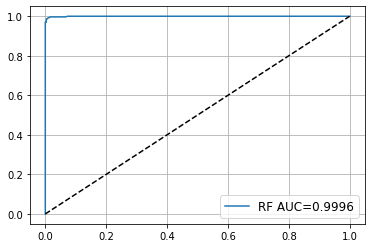

In [14]:
plot_roc_auc(y_val, y_pred, model_name='RF')

### Fine-tuning

Попробуем добиться лучшего качества модели путем ее дообучения

In [15]:
class ResnetFinetune(nn.Module):
    def __init__(self):
        super(ResnetFinetune, self).__init__()
        self.net = torchvision.models.resnet50(pretrained=True)
        self.net.fc = nn.Sequential(
            nn.Linear(self.net.fc.in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(256, 1)
        )

    def fresh_parameters(self):
        return self.net.fc.parameters()

    def forward(self, x):
        return self.net(x)

In [16]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, labels, shape):
        self._fnames = fnames
        self._labels = labels
        self._shape = shape
        self._transform = torchvision.transforms.Compose([
            
            torchvision.transforms.Resize(shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        fname = self._fnames[index]
        img = Image.open(fname).convert('RGB')
        img = self._transform(img)

        return img, self._labels[index]

    def __len__(self):
        return len(self._fnames)

In [17]:
def calculate_correct(y_true, y_pred):
    correct = (y_true == y_pred).squeeze()

    return correct.sum()

In [18]:
class Trainer:    
    def __init__(self, model, criterion, config, device='cuda'):
        self._model = model
        self._device = device
        self._criterion = criterion
        self._epochs = config['epochs']

        if config['only_top']:
            self._optimizer = torch.optim.Adam(self._model.fresh_parameters(), lr=config['lr'])
        else:
            self._optimizer = torch.optim.Adam(self._model.parameters(), lr=config['lr'])        

        self._model.to(self._device)

    def fit(self, train_loader, val_loader):
        for epoch in range(self._epochs):
            self._model.train()
            train_loss, train_accuracy = self._run_epoch(epoch, train_loader, is_training=True)
            print('Train. loss: {}, accuracy: {}'.format(train_loss, train_accuracy))
            
            self._model.eval()
            val_loss, val_accuracy = self._run_epoch(epoch, val_loader, is_training=False)
            print('Validation. loss: {}, accuracy: {}'.format(val_loss, val_accuracy))

    def _run_epoch(self, epoch, loader, is_training):
        loss = 0
        correct = 0
        if is_training:
            pbar = tqdm.tqdm(enumerate(loader), total=len(loader), desc='Epoch {}'.format(epoch), ncols=0)
        else:
            pbar = tqdm.tqdm(enumerate(loader), total=len(loader), desc='Val', ncols=0)
        
        for i, data in pbar:
            batch_loss, batch_correct = self._step(data, is_training)
            loss += batch_loss
            correct += batch_correct
        
        pbar.close()
        loss /= len(loader)
        accuracy = correct / len(loader.dataset)

        return loss, accuracy
    
    def _step(self, data, is_training=True):
        images = data[0].to(self._device)
        y_true = data[1].to(self._device)

        if is_training:
            self._optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            y_pred = self._model(images)
            y_pred = y_pred.squeeze()
            loss = self._criterion(y_pred, y_true.float())

            if is_training:
                loss.backward()
                self._optimizer.step()
            
        probas = torch.sigmoid(y_pred)
        labels = (probas > 0.5).int()
        correct = calculate_correct(y_true=y_true, y_pred=labels)

        return loss.item(), correct.item()

Сначала будем учить только добавленные нами слои

In [19]:
model = ResnetFinetune()

In [20]:
batch_size = 8
num_workers = 16
shape = (224, 224)

train_dataset = CatsDogsDataset(train_fnames, y_train, shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)

val_dataset = CatsDogsDataset(val_fnames, y_val, shape)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)

In [21]:
config = {
    'lr': 1e-3,
    'epochs': 10,
    'only_top': True
}

trainer = Trainer(model, nn.BCEWithLogitsLoss(), config, device='cuda')
trainer.fit(train_loader, val_loader)

Epoch 0: 100% 175/175 [00:06<00:00, 26.70it/s]

Train. loss: 0.2878206517600587, accuracy: 0.8728571428571429



Val: 100% 75/75 [00:01<00:00, 63.18it/s]

Validation. loss: 0.07327219239746531, accuracy: 0.97



Epoch 1: 100% 175/175 [00:06<00:00, 27.31it/s]

Train. loss: 0.15005938535024013, accuracy: 0.9371428571428572



Val: 100% 75/75 [00:01<00:00, 62.76it/s]

Validation. loss: 0.054956535268574955, accuracy: 0.9766666666666667



Epoch 2: 100% 175/175 [00:06<00:00, 26.98it/s]

Train. loss: 0.21026008424216083, accuracy: 0.9221428571428572



Val: 100% 75/75 [00:01<00:00, 63.05it/s]

Validation. loss: 0.21631858156683545, accuracy: 0.9083333333333333



Epoch 3: 100% 175/175 [00:06<00:00, 26.91it/s]

Train. loss: 0.14856943567083883, accuracy: 0.9428571428571428



Val: 100% 75/75 [00:01<00:00, 62.13it/s]

Validation. loss: 0.06878478900529444, accuracy: 0.97



Epoch 4: 100% 175/175 [00:06<00:00, 26.98it/s]

Train. loss: 0.13731490296045584, accuracy: 0.95



Val: 100% 75/75 [00:01<00:00, 61.97it/s]

Validation. loss: 0.0679237037555625, accuracy: 0.9783333333333334



Epoch 5: 100% 175/175 [00:06<00:00, 26.91it/s]

Train. loss: 0.14632970096543432, accuracy: 0.9442857142857143



Val: 100% 75/75 [00:01<00:00, 62.73it/s]

Validation. loss: 0.054771969655218224, accuracy: 0.985



Epoch 6: 100% 175/175 [00:06<00:00, 26.63it/s]

Train. loss: 0.1765380034090153, accuracy: 0.9378571428571428



Val: 100% 75/75 [00:01<00:00, 62.36it/s]

Validation. loss: 0.09479248276601235, accuracy: 0.9633333333333334



Epoch 7: 100% 175/175 [00:06<00:00, 26.91it/s]

Train. loss: 0.1787045042921922, accuracy: 0.9271428571428572



Val: 100% 75/75 [00:01<00:00, 63.20it/s]

Validation. loss: 0.06555123050386708, accuracy: 0.9716666666666667



Epoch 8: 100% 175/175 [00:06<00:00, 26.89it/s]

Train. loss: 0.15252520369897996, accuracy: 0.94



Val: 100% 75/75 [00:01<00:00, 62.56it/s]

Validation. loss: 0.12611018714184563, accuracy: 0.945



Epoch 9: 100% 175/175 [00:06<00:00, 26.79it/s]

Train. loss: 0.12871772038218166, accuracy: 0.9442857142857143



Val: 100% 75/75 [00:01<00:00, 61.97it/s]

Validation. loss: 0.09869930449562768, accuracy: 0.9516666666666667


In [22]:
class Evaluator:    
    def __init__(self, model, device='cuda'):
        self._model = model
        self._device = device

    def predict(self, loader):
        y_pred = []
        self._model.eval().to(self._device)
        
        with tqdm.tqdm(enumerate(loader), total=len(loader)) as pbar:
            for i, data in pbar:
                batch_pred = self._step(data)
                y_pred.append(batch_pred)
        
        return np.concatenate(y_pred)
    
    def _step(self, data, is_training=True):
        images = data[0].to(self._device)

        with torch.no_grad():
            y_pred = self._model(images)
        
        y_pred = y_pred.squeeze()
        y_pred = torch.sigmoid(y_pred)

        return y_pred.cpu().data.numpy()

In [23]:
evaluator = Evaluator(model, device='cuda')
y_pred = evaluator.predict(val_loader)

100%|██████████| 75/75 [00:01<00:00, 63.73it/s]


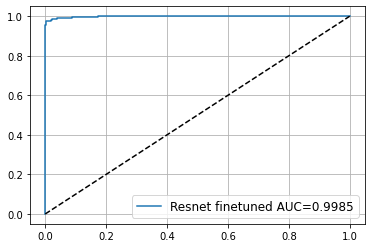

In [24]:
plot_roc_auc(y_val, y_pred, model_name='Resnet finetuned')

Теперь разморозим все веса и обучим несколько эпох с низким *learning rate*

In [25]:
config = {
    'lr': 1e-4,
    'epochs': 10,
    'only_top': False
}

trainer = Trainer(model, nn.BCEWithLogitsLoss(), config, device='cuda')
trainer.fit(train_loader, val_loader)

Epoch 0: 100% 175/175 [00:07<00:00, 22.17it/s]

Train. loss: 0.19543461940650428, accuracy: 0.9314285714285714



Val: 100% 75/75 [00:01<00:00, 61.46it/s]

Validation. loss: 0.07303269700302432, accuracy: 0.9683333333333334



Epoch 1: 100% 175/175 [00:07<00:00, 22.68it/s]

Train. loss: 0.09743821743310296, accuracy: 0.9657142857142857



Val: 100% 75/75 [00:01<00:00, 62.25it/s]

Validation. loss: 0.08422375088208355, accuracy: 0.9616666666666667



Epoch 2: 100% 175/175 [00:07<00:00, 22.78it/s]

Train. loss: 0.0930388945075018, accuracy: 0.9742857142857143



Val: 100% 75/75 [00:01<00:00, 62.74it/s]

Validation. loss: 0.059017783345188944, accuracy: 0.975



Epoch 3: 100% 175/175 [00:07<00:00, 23.07it/s]

Train. loss: 0.07192404488650417, accuracy: 0.9757142857142858



Val: 100% 75/75 [00:01<00:00, 62.57it/s]

Validation. loss: 0.21121353819345434, accuracy: 0.9083333333333333



Epoch 4: 100% 175/175 [00:07<00:00, 23.02it/s]

Train. loss: 0.05034620654968811, accuracy: 0.9835714285714285



Val: 100% 75/75 [00:01<00:00, 63.53it/s]

Validation. loss: 0.09905175955054195, accuracy: 0.965



Epoch 5: 100% 175/175 [00:07<00:00, 23.12it/s]

Train. loss: 0.05476120562907973, accuracy: 0.9835714285714285



Val: 100% 75/75 [00:01<00:00, 62.95it/s]


Validation. loss: 0.07595083080833623, accuracy: 0.965


Epoch 6: 100% 175/175 [00:07<00:00, 23.01it/s]

Train. loss: 0.029514970740794004, accuracy: 0.9914285714285714



Val: 100% 75/75 [00:01<00:00, 62.90it/s]

Validation. loss: 0.18471266158638172, accuracy: 0.945



Epoch 7: 100% 175/175 [00:07<00:00, 22.75it/s]

Train. loss: 0.06609302335917684, accuracy: 0.985



Val: 100% 75/75 [00:01<00:00, 62.20it/s]

Validation. loss: 0.14222137823700906, accuracy: 0.9466666666666667



Epoch 8: 100% 175/175 [00:07<00:00, 22.59it/s]

Train. loss: 0.030380946527501302, accuracy: 0.9907142857142858



Val: 100% 75/75 [00:01<00:00, 62.32it/s]

Validation. loss: 0.11642067892981382, accuracy: 0.955



Epoch 9: 100% 175/175 [00:07<00:00, 22.94it/s]

Train. loss: 0.022721332098548635, accuracy: 0.9921428571428571



Val: 100% 75/75 [00:01<00:00, 62.09it/s]

Validation. loss: 0.12661882306216285, accuracy: 0.9516666666666667


In [26]:
evaluator = Evaluator(model, device='cuda')
y_pred = evaluator.predict(val_loader)

100%|██████████| 75/75 [00:01<00:00, 63.34it/s]


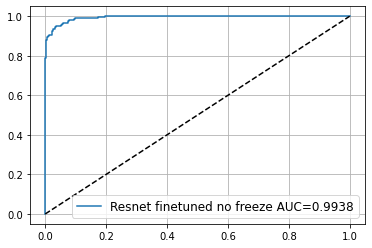

In [27]:
plot_roc_auc(y_val, y_pred, model_name='Resnet finetuned no freeze')

## Пишем свою CNN

### Типичные ошибки

Рассмотрим несколько примеров архитектур в связке с функциями потерь и попробуем найти какие-то проблемы

Для простоты будем использовать `nn.Sequential`

#### Задача 1

Предсказать стоимость автомобиля, на вход 100 признаков, описывающих автомобиль

In [28]:
model = nn.Sequential(
    nn.BatchNorm2d(num_features=100),
    nn.Linear(in_features=3, out_features=256),
    nn.Linear(in_features=256, out_features=256),
    nn.Linear(in_features=256, out_features=1)
)

loss = nn.MSELoss()

#### Задача 2

MNIST: Распознать рукописную цифру (0-9), на вход ч/б картинка 28x28 пикселей

In [29]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=512, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),
    
    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),

    nn.Flatten(),
    nn.Linear(in_features=256, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(in_features=100, out_features=10),
    nn.Sigmoid(),
    nn.Dropout(0.1)
)

loss = nn.MSELoss()

#### Задача 3

Бинарная классификация изображений, на вход картинка RGB 100x100 пикселей

In [30]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(10, 10)),
    nn.Softmax(),
    nn.MaxPool2d((6, 6)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(10, 10)),
    nn.Softmax(),
    nn.MaxPool2d((6, 6)),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(10, 10)),
    nn.Softmax(),
    nn.MaxPool2d((6, 6)),
    
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=256),
    nn.Softmax(),
    nn.Dropout(0.8),
    nn.Linear(in_features=256, out_features=1)
)

loss = nn.BCEWithLogitsLoss()

### MNIST

Напишем свою сетку для решения задачи распознавания рукописных чисел

Датасет содержит ч/б изображения размером 28x28 пикселей

Также реализуем `early_stopping` и попробуем `lr_scheduler.ReduceLROnPlateau`

In [31]:
class MNISTTrainer:    
    def __init__(self, model, criterion, config, device='cuda'):
        self._model = model
        self._device = device
        self._criterion = criterion
        
        self._model.to(self._device)
        
        self._epochs = config['epochs']
        self._early_stopping = config['early_stopping']
              
        self._optimizer = torch.optim.Adam(self._model.parameters(), lr=config['lr'])
        self._scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self._optimizer,
            'min',
            factor=config['lr_reduce_rate'],
            patience=config['patience'],
            verbose=True,
        )
        
        self._best_loss = float('inf')
        self._best_epoch = -1

    def fit(self, train_loader, val_loader):
        for epoch in range(self._epochs):
            self._model.train()
            train_loss, train_accuracy = self._run_epoch(epoch, train_loader, is_training=True)
            print('Train. loss: {}, accuracy: {}'.format(train_loss, train_accuracy))
            
            self._model.eval()
            val_loss, val_accuracy = self._run_epoch(epoch, val_loader, is_training=False)
            print('Validation. loss: {}, accuracy: {}'.format(val_loss, val_accuracy))

            self._scheduler.step(val_loss)
           
            if self._best_loss > val_loss:
                self._best_loss = val_loss
                self._best_epoch = epoch

            if abs(self._best_epoch - epoch) > self._early_stopping:
                print('Early stopping. Epoch {}. Best epoch: {}, best {}: {}'.format(epoch, self._best_epoch))
                break
    
    def _run_epoch(self, epoch, loader, is_training):
        loss = 0
        correct = 0
        if is_training:
            pbar = tqdm.tqdm(enumerate(loader), total=len(loader), desc='Epoch {}'.format(epoch))
        else:
            pbar = enumerate(loader)
        
        for i, data in pbar:
            batch_loss, batch_correct = self._step(data, is_training)
            loss += batch_loss
            correct += batch_correct
        
        if is_training:
            pbar.close()

        loss /= len(loader)
        accuracy = correct / len(loader.dataset)

        return loss, accuracy
    
    def _step(self, data, is_training=True):
        metrics_values = {}
        images = data[0].to(self._device)
        y_true = data[1].to(self._device)

        if is_training:
            self._optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            y_pred = self._model(images)
            y_pred = y_pred.squeeze()
            loss = self._criterion(y_pred, y_true)

            if is_training:
                loss.backward()
                self._optimizer.step()
            
        probas = torch.softmax(y_pred, dim=0)
        labels = probas.max(1)[1]
        correct = calculate_correct(y_true=y_true, y_pred=labels)

        return loss.item(), correct.item()

In [32]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d((2, 2))
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3))
        self.drop = nn.Dropout2d(p=0.5)

        self.classifier = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
    
        x = self.classifier(x)

        return x

In [33]:
model = MNISTModel()

In [34]:
batch_size = 64
num_workers = 0


train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=(-10, 10)),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='data', train=True, download=False, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
val_dataset = torchvision.datasets.MNIST(root='data', train=False, download=False, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)

In [35]:
config = {
    'lr': 1e-3,
    'epochs': 10,
    'early_stopping': 5,
    'lr_reduce_rate': 0.5,
    'patience': 3
}

trainer = MNISTTrainer(model, nn.CrossEntropyLoss(), config, device='cuda')
trainer.fit(train_loader, val_loader)

Epoch 0: 100%|██████████| 938/938 [00:09<00:00, 102.76it/s]


Train. loss: 0.6038942220114442, accuracy: 0.6787833333333333


Epoch 1:   1%|          | 11/938 [00:00<00:09, 100.89it/s]

Validation. loss: 0.11715370245799897, accuracy: 0.9324


Epoch 1: 100%|██████████| 938/938 [00:09<00:00, 104.06it/s]


Train. loss: 0.22034527461872552, accuracy: 0.7926333333333333


Epoch 2:   1%|          | 10/938 [00:00<00:09, 96.20it/s]

Validation. loss: 0.07229494674807521, accuracy: 0.9464


Epoch 2: 100%|██████████| 938/938 [00:09<00:00, 103.55it/s]


Train. loss: 0.16363927040463572, accuracy: 0.8077333333333333


Epoch 3:   1%|          | 9/938 [00:00<00:10, 85.35it/s]

Validation. loss: 0.0697298247106136, accuracy: 0.946


Epoch 3: 100%|██████████| 938/938 [00:09<00:00, 103.91it/s]


Train. loss: 0.13992996331550547, accuracy: 0.8283666666666667


Epoch 4:   1%|          | 9/938 [00:00<00:10, 85.98it/s]

Validation. loss: 0.04463760503775375, accuracy: 0.9591


Epoch 4: 100%|██████████| 938/938 [00:09<00:00, 104.00it/s]


Train. loss: 0.11489867783193268, accuracy: 0.8428833333333333


Epoch 5:   1%|          | 11/938 [00:00<00:09, 102.11it/s]

Validation. loss: 0.043123202434011326, accuracy: 0.9648


Epoch 5: 100%|██████████| 938/938 [00:08<00:00, 104.42it/s]


Train. loss: 0.10441793640579052, accuracy: 0.8527333333333333


Epoch 6:   1%|          | 9/938 [00:00<00:11, 83.94it/s]

Validation. loss: 0.03670121271424233, accuracy: 0.9671


Epoch 6: 100%|██████████| 938/938 [00:08<00:00, 104.73it/s]


Train. loss: 0.09541477648013119, accuracy: 0.8601833333333333


Epoch 7:   1%|          | 11/938 [00:00<00:08, 104.12it/s]

Validation. loss: 0.03387350055157758, accuracy: 0.9728


Epoch 7: 100%|██████████| 938/938 [00:09<00:00, 103.91it/s]


Train. loss: 0.0881238277934031, accuracy: 0.8653666666666666


Epoch 8:   1%|          | 9/938 [00:00<00:10, 89.29it/s]

Validation. loss: 0.032863025227264996, accuracy: 0.9761


Epoch 8: 100%|██████████| 938/938 [00:09<00:00, 104.20it/s]


Train. loss: 0.08154705729780358, accuracy: 0.8716166666666667


Epoch 9:   1%|          | 8/938 [00:00<00:12, 77.39it/s]

Validation. loss: 0.03211857551696953, accuracy: 0.9708


Epoch 9: 100%|██████████| 938/938 [00:10<00:00, 89.46it/s]


Train. loss: 0.07607442611999223, accuracy: 0.8775833333333334
Validation. loss: 0.030063325616347183, accuracy: 0.9765
